In [1]:
import pandas as pd
import os
from os.path import dirname, abspath
import matplotlib.pyplot as plt
import seaborn as sb
import librosa
import librosa.display
import numpy as np

data_path = '../Data/'

In [2]:
train_fp_data = pd.read_csv(data_path+'train_fp.csv')
train_tp_data = pd.read_csv(data_path+'train_tp.csv')

Basic Information: There is over 6x as much false positive data as true positive. In order to get accurate results we will need to utilize that data heavily

In [3]:
print('Number of rows in true positive data: '+str(len(train_tp_data)))
print('Number of rows in false positive data: '+str(len(train_fp_data)))

Number of rows in true positive data: 1216
Number of rows in false positive data: 7781


Data Types: Unsurprisingly, the data set is complete and has no null values. Other than the audio data, all the provided information is numeric.

In [4]:
print('true positive data')
print(train_tp_data.info());
print()
print('false positive data')
print(train_fp_data.info());

true positive data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recording_id  1216 non-null   object 
 1   species_id    1216 non-null   int64  
 2   songtype_id   1216 non-null   int64  
 3   t_min         1216 non-null   float64
 4   f_min         1216 non-null   float64
 5   t_max         1216 non-null   float64
 6   f_max         1216 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 66.6+ KB
None

false positive data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7781 entries, 0 to 7780
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recording_id  7781 non-null   object 
 1   species_id    7781 non-null   int64  
 2   songtype_id   7781 non-null   int64  
 3   t_min         7781 non-null   float64
 4   f_min         7781 non-null   

Unique Columns Values: It is interesting that there is only 2 songtype ids. We also know we have 24 species to evaluate. Interestingly, there is 1132 unique recording ids for the true positive data set, meaning that that that is only slightly over 1 true positive data for each recording. In contrast, there is almost 2 false positives for each recording.

In [5]:
print('true positive data')
print(train_tp_data.nunique())
print()
print('false positive data')
print(train_fp_data.nunique())

true positive data
recording_id    1132
species_id        24
songtype_id        2
t_min           1162
f_min             27
t_max           1167
f_max             32
dtype: int64

false positive data
recording_id    3958
species_id        24
songtype_id        2
t_min           6090
f_min             24
t_max           6089
f_max             30
dtype: int64


True Positive Correlation: Unsurprisingly the t_min and t_max correlate strongly as do the f_min and f_max. There is a non-insignificant correlation between species and frequency. Perhaps we can focus on those audio ranges to have a better analysis.

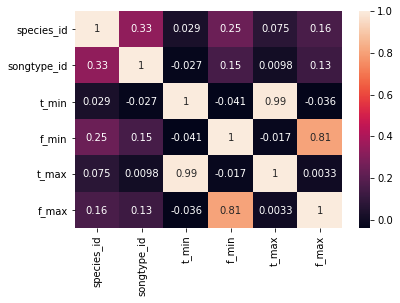

In [6]:
sb.heatmap(train_tp_data.corr(),annot=True);

False Positive Correlation: Unsurprisingly the correlation here matches the True Positive Correlation pretty closely

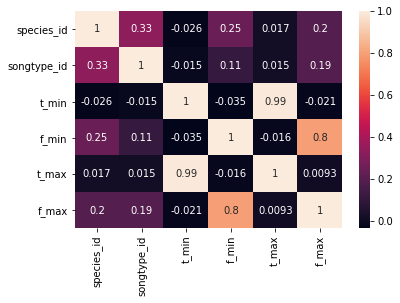

In [7]:
sb.heatmap(train_fp_data.corr(),annot=True);

Time of Data: In most cases the identification is done in under 2-3 seconds of audio.

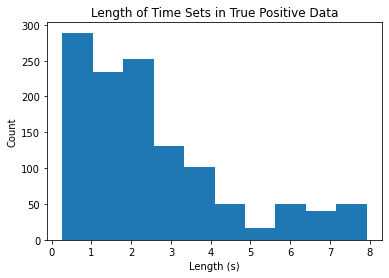

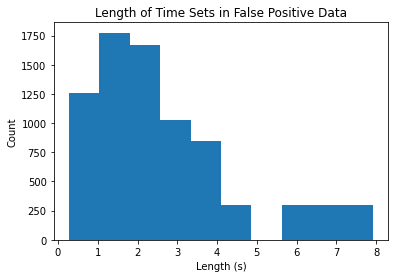

In [8]:
plt.hist(train_tp_data['t_max']-train_tp_data['t_min']);
plt.xlabel('Length (s)');
plt.ylabel('Count');
plt.title('Length of Time Sets in True Positive Data');
plt.figure();
plt.hist(train_fp_data['t_max']-train_fp_data['t_min']);
plt.xlabel('Length (s)');
plt.ylabel('Count');
plt.title('Length of Time Sets in False Positive Data');

Frequency Ranges: The difference between minimum and maximum frequency is typically in the thousands. Considering the total range is below 13,000, this means the frequency ranges are pretty broad. Perhaps, we can find the middle and assume a Gaussian distribution to improve our predictions.

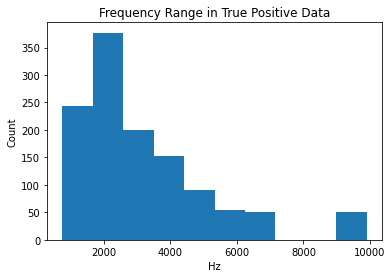

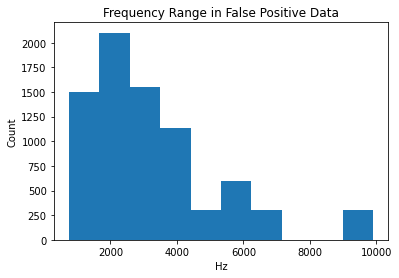

In [9]:
plt.hist(train_tp_data['f_max']-train_tp_data['f_min']);
plt.xlabel('Hz');
plt.ylabel('Count');
plt.title('Frequency Range in True Positive Data');
plt.figure();
plt.hist(train_fp_data['f_max']-train_fp_data['f_min']);
plt.xlabel('Hz');
plt.ylabel('Count');
plt.title('Frequency Range in False Positive Data');

Frequency Distribution: The max frequency seems to have a much higher variation than the minimum. We were a bit confused on how the frequencies were drawn. There was 1-3 unique frequencies per species and song type. The number of unique minimum frequencies did not always match the number of unique maximum frequencies. This is something we are going to investigate further.

true positive
            recording_id  songtype_id  t_min  f_min  t_max  f_max
species_id                                                       
0                     50            1     50      1     50      2
1                     50            1     50      1     50      1
2                     30            1     37      1     37      1
3                     50            1     50      1     50      1
4                     50            1     49      2     49      2
5                     50            1     50      2     50      2
6                     49            1     50      1     50      2
7                     50            1     50      1     50      1
8                     50            1     50      1     50      1
9                     33            1     34      2     34      2
10                    49            1     50      1     50      1
11                    50            1     50      1     50      1
12                    50            1     50      1     50    

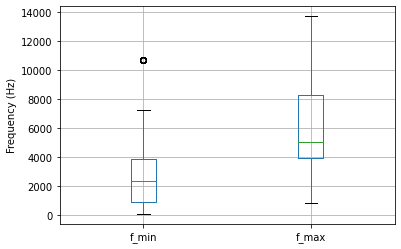

In [10]:
print('true positive')
print(train_tp_data.groupby('species_id').nunique())
print('')
print('false positive')
print(train_fp_data.groupby('species_id').nunique())
train_tp_data.boxplot(column=['f_min', 'f_max']);
plt.ylabel('Frequency (Hz)');

Species Distribution: Species 17 and 23 have more data than the other species in both the false positive and true positive data. The other species have roughly equal data but a few do have slightly less in the true positive data. Perhaps we can use the increased data on 17 and 23 to develop a better prediction model for standard species behavior that could be applied to all the other species.

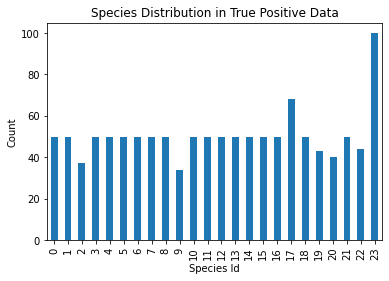

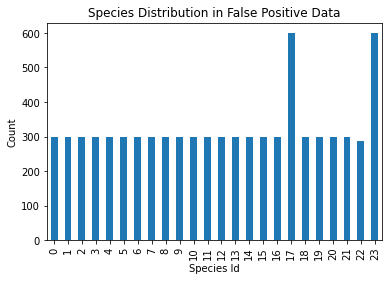

In [11]:
train_tp_data['species_id'].value_counts().sort_index().plot(kind='bar');
plt.xlabel('Species Id');
plt.ylabel('Count');
plt.title('Species Distribution in True Positive Data');
plt.figure();
train_fp_data['species_id'].value_counts().sort_index().plot(kind='bar');
plt.xlabel('Species Id');
plt.ylabel('Count');
plt.title('Species Distribution in False Positive Data');

Song Type Distribution: The only species with multiple song types are 17 and 23. This explains why they have twice as much data, because they are making two different calls. It might make sense to treat them as separate identifications for our training, so the model is not confused by two seemingly vastly different sounds being the same species.

In [12]:
train_tp_data.groupby('species_id')['songtype_id'].nunique()

species_id
0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    2
18    1
19    1
20    1
21    1
22    1
23    2
Name: songtype_id, dtype: int64

Audio: The audio is sampled at 48000 Hz meaning that there are 48000 points of data per second. In both the test and train sets, each audio is 60 seconds.

In [13]:
audio_path = data_path+'train/0a4e7e350.flac'
x, sr = librosa.load(audio_path, sr=None)
print(str(sr) + ' Hz')
print(str(np.shape(x)[0]/sr) + ' seconds')

48000 Hz
60.0 seconds


Waveforms: Interestingly, by looking at a few random files, there does not seem to be a consistency to the waveforms of the audio. Perhaps we can use this to get a better read on the environment of the recording and use that to predict species presence. In particular maybe we can look into the period of the high frequency sounds and work from there.

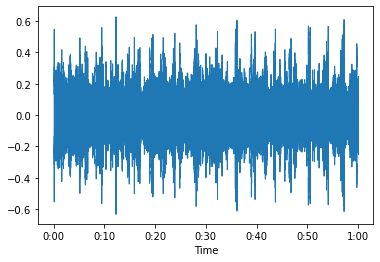

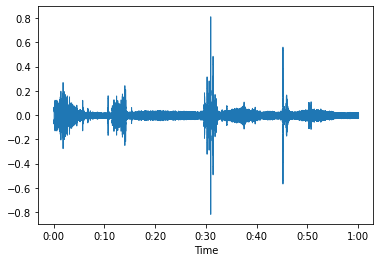

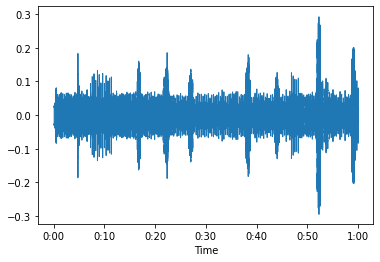

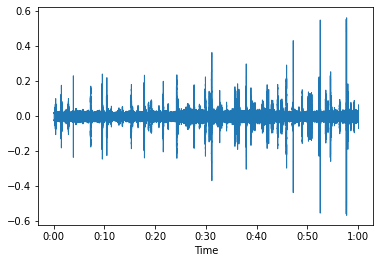

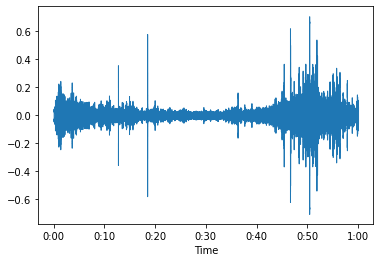

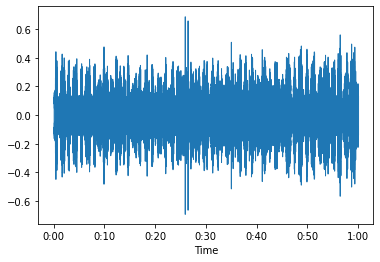

In [14]:
x, sr = librosa.load(data_path+'train/3447ebcd4.flac', sr=None)
librosa.display.waveshow(x, sr=sr);
plt.figure()
x, sr = librosa.load(data_path+'train/0a4f02024.flac', sr=None)
librosa.display.waveshow(x, sr=sr);
plt.figure()
x, sr = librosa.load(data_path+'train/0b306a59b.flac', sr=None)
librosa.display.waveshow(x, sr=sr);
plt.figure()
x, sr = librosa.load(data_path+'train/bfc900065.flac', sr=None)
librosa.display.waveshow(x, sr=sr);
plt.figure()
x, sr = librosa.load(data_path+'train/f829230cd.flac', sr=None)
librosa.display.waveshow(x, sr=sr);
plt.figure()
x, sr = librosa.load(data_path+'train/c146d2422.flac', sr=None)
librosa.display.waveshow(x, sr=sr);